#### Каждый признак в датасете предоставляет информацию о поведении и характеристиках клиента:

- recency: Сколько месяцев прошло с момента последней покупки клиента. Более низкое значение может указывать на более активного клиента.

- history: Общая сумма трат клиента за прошлый год. Этот признак отражает его историческую ценность.

- used_discount: Бинарный признак (1 или 0), указывающий, использовал ли клиент скидки в прошлом.

- used_bogo: Бинарный признак (1 или 0), указывающий, использовал ли клиент акцию "Купи один, получи второй бесплатно" (BOGO).

- zip_code: Категориальный признак, указывающий на тип места жительства клиента (например, Surburban, Rural).

- is_referral: Бинарный признак (1 или 0), указывающий, пришел ли клиент по рекомендации.

- channel: Канал, через который клиент взаимодействует с компанией (Phone, Web, Multichannel).

- offer: Предложение, которое было сделано клиенту (Buy One Get One, Discount, No Offer). Это ключевой признак для uplift-моделирования, так как он определяет, к какой группе относится клиент — контрольной (No Offer) или экспериментальной (Buy One Get One, Discount).

- conversion: Бинарный целевой признак (1 или 0), указывающий, совершил ли клиент покупку в результате предложения.

#### Группы пользователей для сегментации
Для uplift-моделирования необходимо разделить пользователей на группы на основе двух ключевых признаков: offer и conversion. Это позволяет определить четыре категории, которые являются основой для анализа uplift'а:

- Контрольная группа (offer = No Offer):

    - True Negatives (TN): Клиенты, которые не получили предложение и не совершили конверсию.

    - True Positives (TP): Клиенты, которые не получили предложение, но совершили конверсию.

- Экспериментальная группа (offer = Buy One Get One или Discount):

    - False Negatives (FN): Клиенты, которые получили предложение, но не совершили конверсию.

    - False Positives (FP): Клиенты, которые получили предложение и совершили конверсию.

Анализ этих групп позволяет выявить, какие клиенты чувствительны к предложению (treatment-responsive) и увеличивают свою вероятность конверсии благодаря ему. Модель uplift-моделирования будет стремиться идентифицировать тех клиентов, у которых рост вероятности конверсии (разница между FP и TP) будет наибольшим. Это помогает оптимизировать маркетинговые кампании, направляя их только на тех, кто с наибольшей вероятностью отреагирует на предложение.

In [1]:
import pandas as pd
data = pd.read_csv("/kaggle/input/customer-retention/data.csv")
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


АНАЛИЗ ДАТАСЕТА
ОСНОВНАЯ СТАТИСТИКА ПО ДАТАСЕТУ

1. ОСНОВНАЯ ИНФОРМАЦИЯ:
Размер датасета: 64000 строк, 11 столбцов
Размер в памяти: 15.69 MB

2. ТИПЫ ДАННЫХ:
int64      5
float64    3
object     3
Name: count, dtype: int64

3. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
Пропущенных значений нет!

4. ДУБЛИКАТЫ: 6603 полных дубликатов

5. СТАТИСТИКА ПО ЧИСЛОВЫМ ПЕРЕМЕННЫМ:
            recency       history  used_discount     used_bogo   is_referral  \
count  64000.000000  64000.000000   64000.000000  64000.000000  64000.000000   
mean       5.763734    242.085656       0.551031      0.549719      0.502250   
std        3.507592    256.158608       0.497393      0.497526      0.499999   
min        1.000000     29.990000       0.000000      0.000000      0.000000   
25%        2.000000     64.660000       0.000000      0.000000      0.000000   
50%        6.000000    158.110000       1.000000      1.000000      1.000000   
75%        9.000000    325.657500       1.000000      1.000000      1.000000   
max     

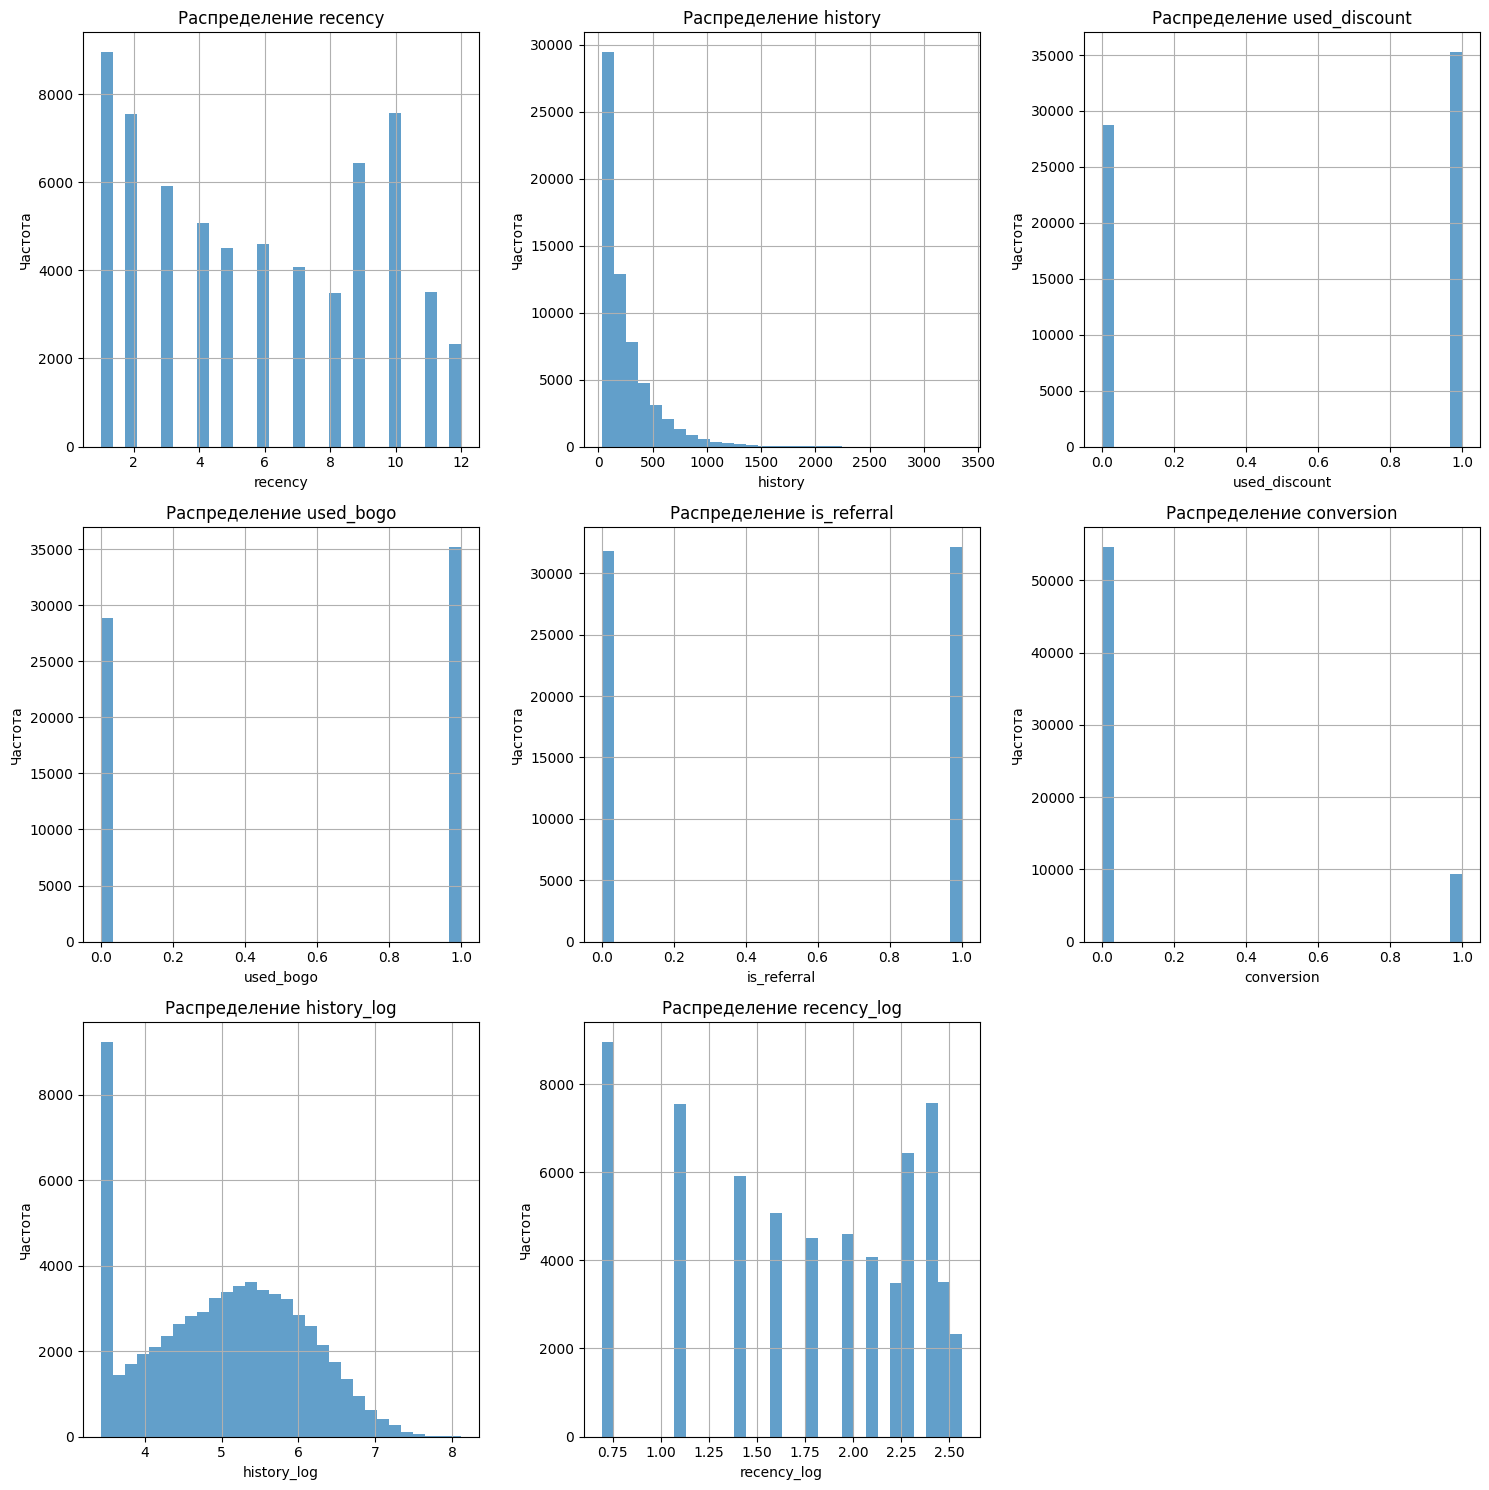

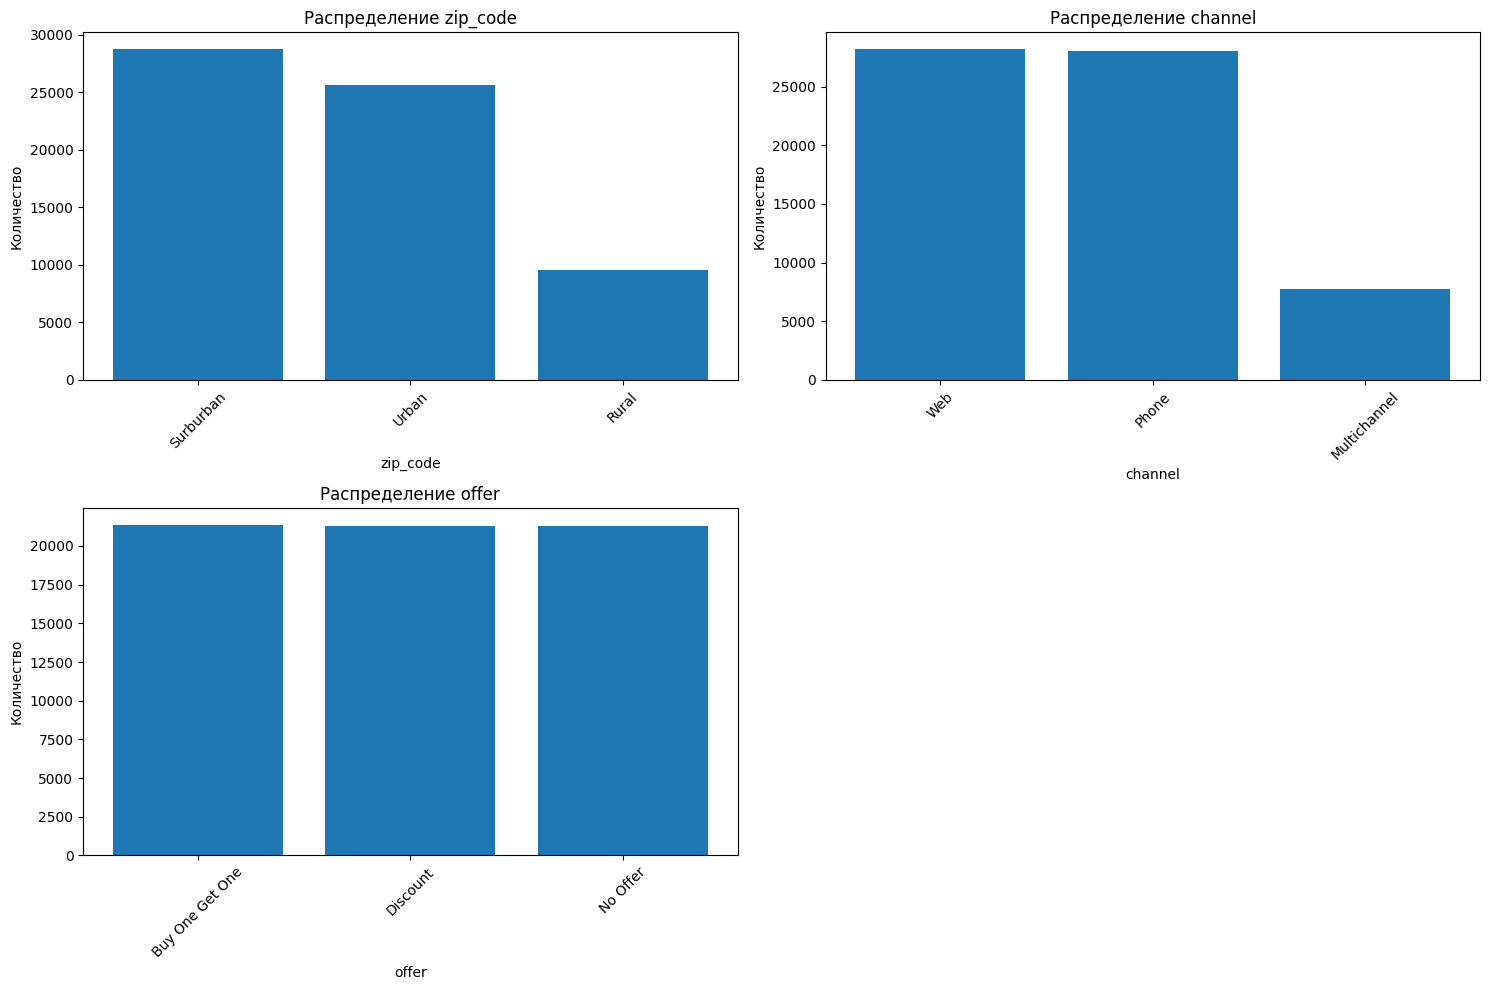

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


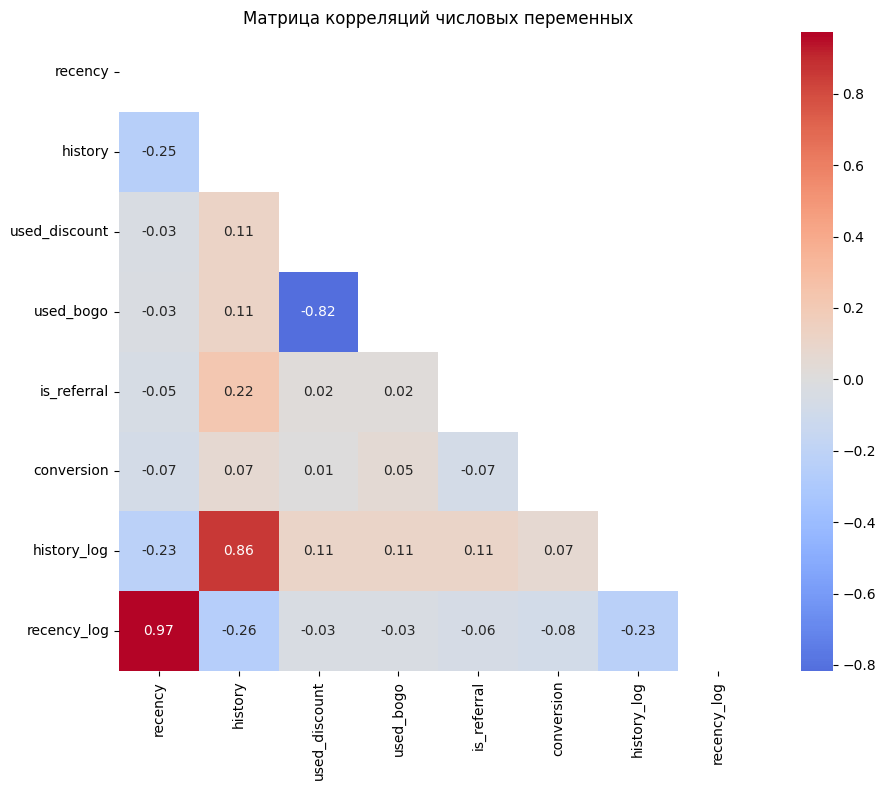

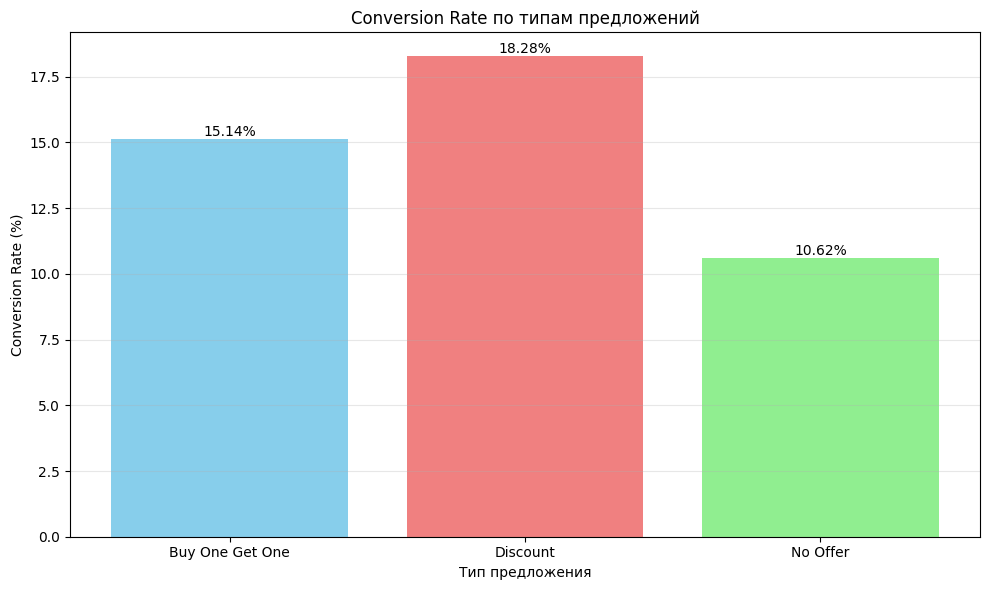


ДЕТАЛЬНЫЙ АНАЛИЗ ПО ГРУППАМ ПРЕДЛОЖЕНИЙ
                conversion               
                      mean     std  count
offer                                    
Buy One Get One      15.14  0.3584  21387
Discount             18.28  0.3865  21307
No Offer             10.62  0.3081  21306

СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ РАЗЛИЧИЙ:
Buy One Get One vs No Offer: t-statistic = 13.9807, p-value = 0.0000
Buy One Get One vs Discount: t-statistic = -8.6920, p-value = 0.0000
No Offer vs Discount: t-statistic = -22.6201, p-value = 0.0000

ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Датасет содержит данные о 64000 клиентах
Временные метки не обнаружены
Баланс групп: соотношение размеров = 1.00
Группы достаточно сбалансированы


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def basic_dataset_statistics(df):
    """
    Выводит основную статистику по датасету.
    """
    print("=" * 80)
    print("ОСНОВНАЯ СТАТИСТИКА ПО ДАТАСЕТУ")
    print("=" * 80)
    
    # 1. Базовая информация о датасете
    print("\n1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
    print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print(f"Размер в памяти: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # 2. Информация о типах данных
    print("\n2. ТИПЫ ДАННЫХ:")
    print(df.dtypes.value_counts())
    
    # 3. Пропущенные значения
    print("\n3. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_info = pd.DataFrame({
        'Количество пропусков': missing_data,
        'Процент пропусков': missing_percent
    })
    missing_info = missing_info[missing_info['Количество пропусков'] > 0]
    if len(missing_info) > 0:
        print(missing_info)
    else:
        print("Пропущенных значений нет!")
    
    # 4. Дубликаты
    print(f"\n4. ДУБЛИКАТЫ: {df.duplicated().sum()} полных дубликатов")
    
    # 5. Статистика по числовым колонкам
    print("\n5. СТАТИСТИКА ПО ЧИСЛОВЫМ ПЕРЕМЕННЫМ:")
    if len(df.select_dtypes(include=[np.number]).columns) > 0:
        print(df.describe())
    
    # 6. Статистика по категориальным колонкам
    print("\n6. СТАТИСТИКА ПО КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ:")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        print(f"\n--- {col} ---")
        print(f"Уникальных значений: {df[col].nunique()}")
        print("Распределение:")
        print(df[col].value_counts(normalize=True).head(10))
        if df[col].nunique() > 10:
            print(f"... и еще {df[col].nunique() - 10} уникальных значений")
    
    # 7. Анализ целевой переменной (conversion)
    if 'conversion' in df.columns:
        print("\n7. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (CONVERSION):")
        conversion_stats = df['conversion'].value_counts()
        conversion_rate = df['conversion'].mean() * 100
        print(f"Общий conversion rate: {conversion_rate:.2f}%")
        print(f"Распределение: 0 - {conversion_stats[0]} ({conversion_stats[0]/len(df)*100:.1f}%), "
              f"1 - {conversion_stats[1]} ({conversion_stats[1]/len(df)*100:.1f}%)")
    
    # 8. Анализ переменной лечения (offer)
    if 'offer' in df.columns:
        print("\n8. АНАЛИЗ ПРЕДЛОЖЕНИЙ (OFFER):")
        offer_stats = df['offer'].value_counts()
        print("Распределение по группам:")
        for offer, count in offer_stats.items():
            percentage = count / len(df) * 100
            print(f"  {offer}: {count} ({percentage:.1f}%)")
        
        # Conversion rate по группам
        if 'conversion' in df.columns:
            print("\nConversion rate по группам:")
            conversion_by_offer = df.groupby('offer')['conversion'].agg(['mean', 'count'])
            conversion_by_offer['mean'] = conversion_by_offer['mean'] * 100
            print(conversion_by_offer.round(2))
    
    return df

def create_visualizations(df):
    """
    Создает визуализации для анализа датасета.
    """
    print("\n" + "="*80)
    print("ВИЗУАЛИЗАЦИИ")
    print("="*80)
    
    # 1. Распределение числовых переменных
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        n_cols = min(3, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                df[col].hist(bins=30, ax=axes[i], alpha=0.7)
                axes[i].set_title(f'Распределение {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Частота')
        
        # Скрываем пустые subplots
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)
            
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/figs/numeric_distributions.png", dpi=160, bbox_inches="tight")
        plt.show()
    
    # 2. Распределение категориальных переменных (первые 6)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        n_plots = min(6, len(categorical_cols))
        n_cols = 2
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i, col in enumerate(categorical_cols[:n_plots]):
            value_counts = df[col].value_counts().head(10)  # Топ-10 значений
            axes[i].bar(range(len(value_counts)), value_counts.values)
            axes[i].set_title(f'Распределение {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Количество')
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels(value_counts.index, rotation=45)
        
        # Скрываем пустые subplots
        for i in range(n_plots, len(axes)):
            axes[i].set_visible(False)
            
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/figs/categorical_distributions.png", dpi=160, bbox_inches="tight")
        plt.show()
    
    # 3. Матрица корреляций (только для числовых данных)
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_cols].corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f')
        plt.title('Матрица корреляций числовых переменных')
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/figs/correlation_matrix.png", dpi=160, bbox_inches="tight")
        plt.show()
    
    # 4. Анализ conversion rate по группам
    if 'conversion' in df.columns and 'offer' in df.columns:
        plt.figure(figsize=(10, 6))
        conversion_by_offer = df.groupby('offer')['conversion'].mean() * 100
        bars = plt.bar(conversion_by_offer.index, conversion_by_offer.values, 
                      color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Conversion Rate по типам предложений')
        plt.xlabel('Тип предложения')
        plt.ylabel('Conversion Rate (%)')
        plt.grid(axis='y', alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/figs/conversion_by_offer.png", dpi=160, bbox_inches="tight")
        plt.show()

def detailed_offer_analysis(df):
    """
    Детальный анализ по группам предложений.
    """
    if 'offer' in df.columns and 'conversion' in df.columns:
        print("\n" + "="*80)
        print("ДЕТАЛЬНЫЙ АНАЛИЗ ПО ГРУППАМ ПРЕДЛОЖЕНИЙ")
        print("="*80)
        
        # Статистика по группам
        group_analysis = df.groupby('offer').agg({
            'conversion': ['mean', 'std', 'count'],
        }).round(4)
        
        group_analysis[('conversion', 'mean')] = group_analysis[('conversion', 'mean')] * 100
        print(group_analysis)
        
        # T-test для сравнения групп
        offers = df['offer'].unique()
        if len(offers) > 1:
            print("\nСТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ РАЗЛИЧИЙ:")
            for i in range(len(offers)):
                for j in range(i+1, len(offers)):
                    group1 = df[df['offer'] == offers[i]]['conversion']
                    group2 = df[df['offer'] == offers[j]]['conversion']
                    
                    t_stat, p_value = stats.ttest_ind(group1, group2)
                    print(f"{offers[i]} vs {offers[j]}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Запуск анализа
print("АНАЛИЗ ДАТАСЕТА")
print("="*80)

# Основная статистика
df_stats = basic_dataset_statistics(df)

# Визуализации
create_visualizations(df)

# Детальный анализ предложений
detailed_offer_analysis(df)

# Дополнительная информация
print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("="*80)
print(f"Датасет содержит данные о {len(df)} клиентах")
print(f"Период данных: от {df.get('date', pd.Series([pd.NaT])).min()} до {df.get('date', pd.Series([pd.NaT])).max()}" 
      if 'date' in df.columns else "Временные метки не обнаружены")

# Проверка баланса групп
if 'offer' in df.columns:
    offer_counts = df['offer'].value_counts()
    balance_ratio = offer_counts.max() / offer_counts.min()
    print(f"Баланс групп: соотношение размеров = {balance_ratio:.2f}")
    if balance_ratio > 2:
        print("ВНИМАНИЕ: Сильный дисбаланс групп!")
    elif balance_ratio > 1.5:
        print("Умеренный дисбаланс групп")
    else:
        print("Группы достаточно сбалансированы")

Длина датасета 64000
Кол-во столбцов 9
Кол-во пропусков 0


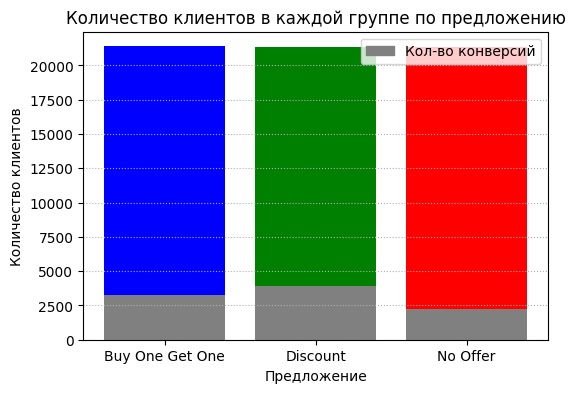

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("Длина датасета", data.shape[0])
print("Кол-во столбцов", data.shape[1])
print("Кол-во пропусков", data.isna().sum().sum())

# Сгруппировать по предложению и посчитать количество клиентов в каждой группе
client_counts = data['offer'].value_counts()
conversion_counts = data.groupby('offer')['conversion'].sum()
# Построить график
plt.figure(figsize=(6, 4))
plt.bar(client_counts.index, client_counts, color=['blue', 'green', 'red'])
plt.bar(conversion_counts.index, conversion_counts, color='gray')
plt.title('Количество клиентов в каждой группе по предложению')
plt.xlabel('Предложение')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle=":")

legend_patch = mpatches.Patch(color='gray', label='Кол-во конверсий')
plt.legend(handles=[legend_patch], loc='upper right')

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


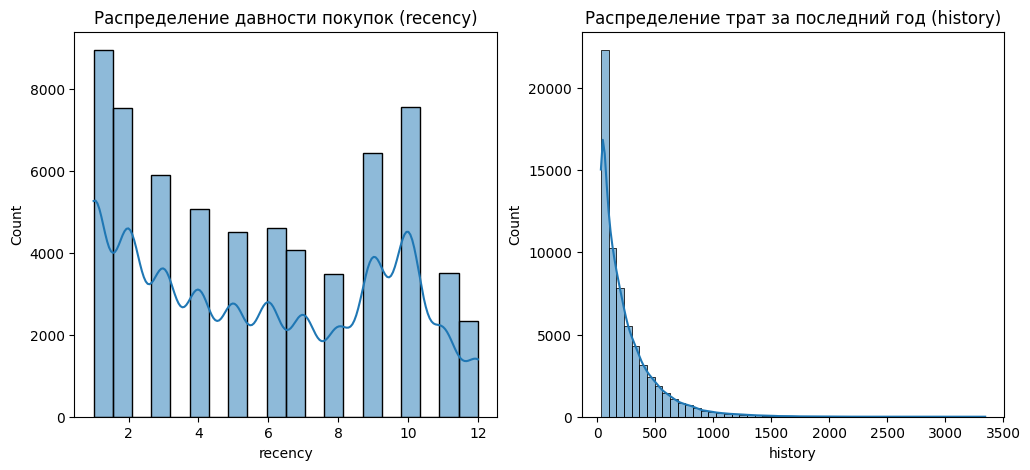

In [3]:
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['recency'], kde=True, bins=20)
plt.title('Распределение давности покупок (recency)')
plt.subplot(1, 2, 2)
sns.histplot(data['history'], kde=True, bins=50)
plt.title('Распределение трат за последний год (history)')
plt.show()

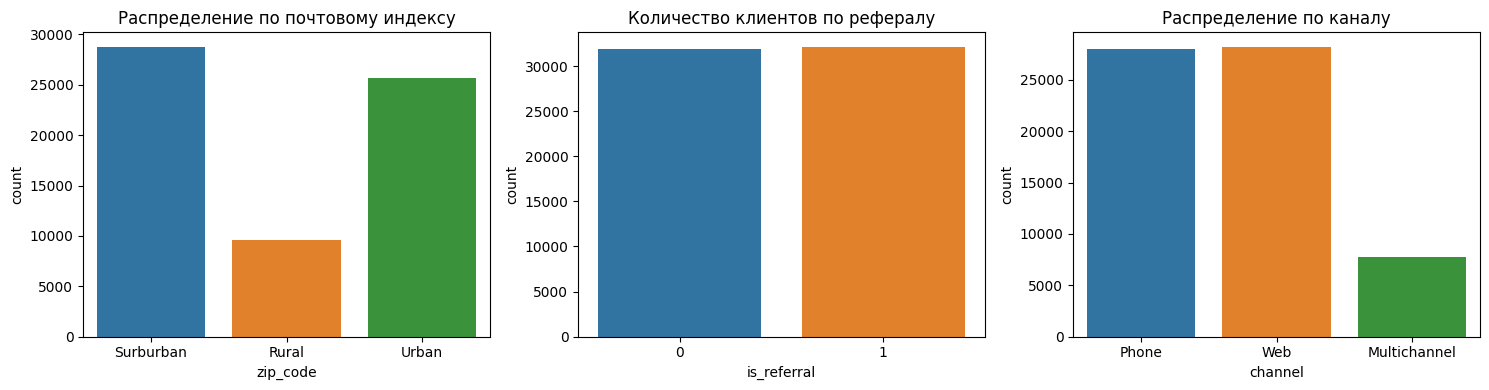

In [4]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='zip_code', data=data)
plt.title('Распределение по почтовому индексу')

plt.subplot(1, 3, 2)
sns.countplot(x='is_referral', data=data)
plt.title('Количество клиентов по рефералу')

plt.subplot(1, 3, 3)
sns.countplot(x='channel', data=data)
plt.title('Распределение по каналу')

plt.tight_layout()
plt.show()

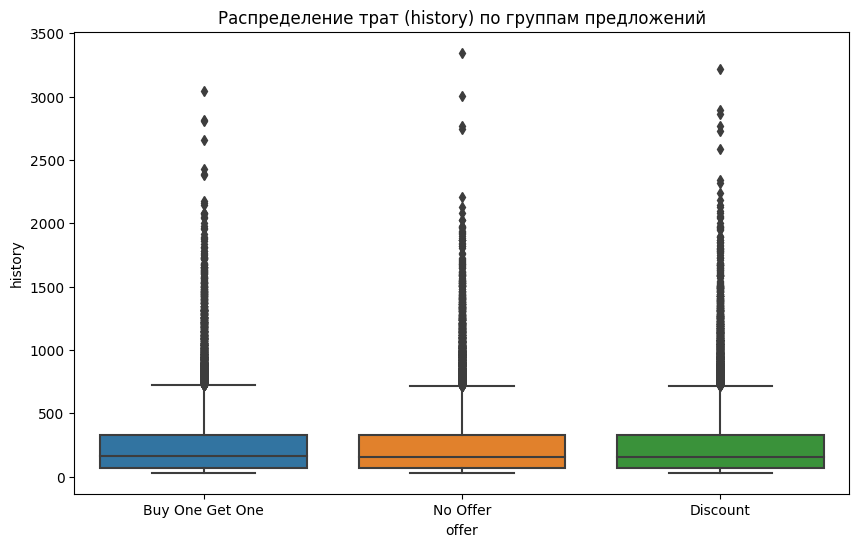

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='offer', y='history', data=data)
plt.title('Распределение трат (history) по группам предложений')
plt.show()

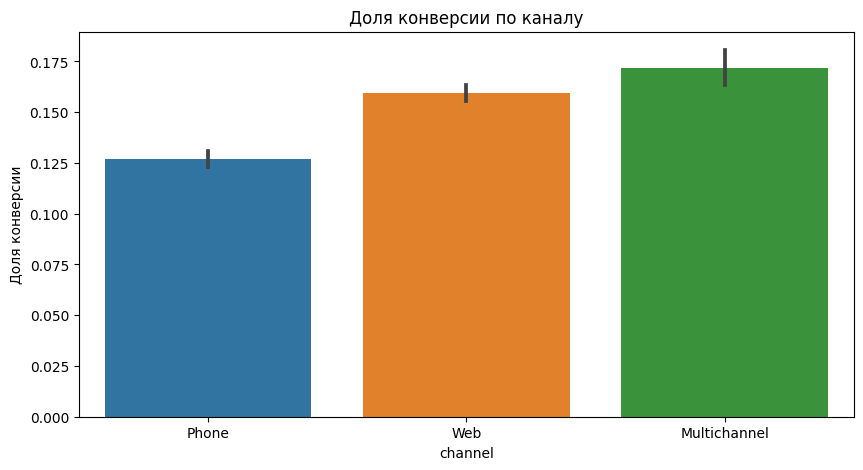

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(x='channel', y='conversion', data=data, estimator=lambda x: sum(x) / len(x))
plt.title('Доля конверсии по каналу')
plt.ylabel('Доля конверсии')
plt.show()

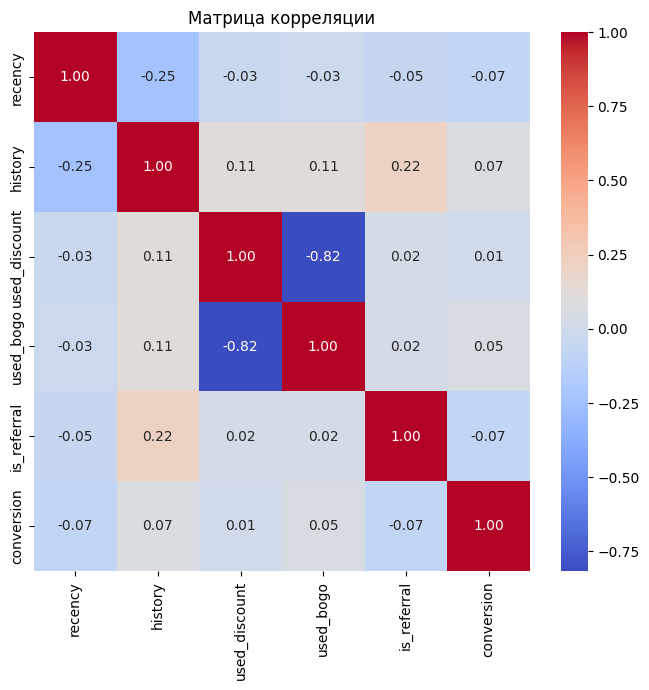

In [7]:
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

In [8]:

# === Config ===
CSV_PATH = "/kaggle/input/customer-retention/data.csv"      # <-- Укажи путь к своему CSV
OUTDIR   = "/kaggle/working/"  # <-- Папка для артефактов
MESSAGE_COST = 5.0                   # Стоимость сообщения
AVG_MARGIN   = 3000.0                # Средняя маржа с заказа
RANDOM_STATE = 42

import os
from pathlib import Path
Path(OUTDIR).mkdir(parents=True, exist_ok=True)
(Path(OUTDIR) / "figs").mkdir(parents=True, exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

In [22]:

# === Load data ===
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), "Cols:", df.shape[1])
print("NA cells:", int(df.isna().sum().sum()))

# Clean up infinities (как рекомендовано вместо use_inf_as_na) — см. примечание в отчёте. fileciteturn1file0
df = df.replace([np.inf, -np.inf], np.nan).dropna()

df.head(3)


Rows: 64000 Cols: 9
NA cells: 0


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [23]:

# === Feature engineering ===
df['history_log'] = np.log1p(df['history'].astype(float))
df['recency_log'] = np.log1p(df['recency'].astype(float))

num_cols = ["recency_log", "history_log"]
cat_cols = ["zip_code", "channel", "is_referral", "used_discount", "used_bogo"]

def build_preprocess():
    return ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ])

def make_clf(random_state=RANDOM_STATE):
    base = XGBClassifier(
        n_estimators=300, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
        random_state=random_state, n_jobs=-1
    )
    return CalibratedClassifierCV(base, method="isotonic", cv=3)


In [24]:

def train_two_model_uplift(local_df, treat_value, random_state=RANDOM_STATE):
    subset = local_df[(local_df['offer']==treat_value) | (local_df['offer']=="No Offer")].copy()
    subset['treat'] = (subset['offer']==treat_value).astype(int)
    y = subset['conversion'].astype(int).values
    t = subset['treat'].astype(int).values
    X = subset[num_cols + cat_cols].copy()

    X_tr, X_te, y_tr, y_te, t_tr, t_te = train_test_split(
        X, y, t, test_size=0.2, stratify=t, random_state=random_state
    )

    prep = build_preprocess()
    model_t = Pipeline([("prep", prep), ("clf", make_clf(random_state))])
    model_c = Pipeline([("prep", prep), ("clf", make_clf(random_state))])

    model_t.fit(X_tr[t_tr==1], y_tr[t_tr==1])
    model_c.fit(X_tr[t_tr==0], y_tr[t_tr==0])

    p_t = model_t.predict_proba(X_te)[:,1]
    p_c = model_c.predict_proba(X_te)[:,1]
    uplift = p_t - p_c

    return dict(X_test=X_te, y_test=y_te, t_test=t_te, uplift=uplift,
                model_t=model_t, model_c=model_c, test_index=X_te.index)


In [25]:

def qini_curve(uplift, y_true, t, n_bins=20):
    order = np.argsort(-uplift)
    y = y_true[order]; tt = t[order]

    cum_t = np.cumsum(tt)
    cum_c = np.cumsum(1 - tt)

    cum_resp_t = np.cumsum(y * tt)
    cum_resp_c = np.cumsum(y * (1 - tt))

    expected_c_scaled = np.where(cum_c>0, cum_resp_c * (cum_t/np.maximum(cum_c,1e-9)), 0.0)
    inc_gain = cum_resp_t - expected_c_scaled

    n = len(uplift)
    edges = (np.linspace(0, n, n_bins+1)).astype(int)[1:]
    x = edges / n
    y = inc_gain[edges-1]
    return x, y, inc_gain

def uplift_curve(uplift, y_true, t, n_bins=20):
    order = np.argsort(-uplift)
    y = y_true[order]; tt = t[order]
    xs, ys = [], []
    n = len(uplift)
    for frac in np.linspace(0.05, 1.0, n_bins):
        k = int(n*frac)
        if k<1: continue
        sel_y = y[:k]; sel_t = tt[:k]
        if sel_t.sum()==0 or (k - sel_t.sum())==0:
            avg_diff = 0.0
        else:
            avg_t = sel_y[sel_t==1].mean() if (sel_t==1).any() else 0.0
            avg_c = sel_y[sel_t==0].mean() if (sel_t==0).any() else 0.0
            avg_diff = avg_t - avg_c
        xs.append(frac); ys.append(avg_diff)
    return np.array(xs), np.array(ys)

def roi_curve(uplift, message_cost, avg_margin, n_bins=20):
    xs, ys = [], []
    n = len(uplift)
    for frac in np.linspace(0.05, 1.0, n_bins):
        k = int(n*frac)
        top_u = np.sort(uplift)[::-1][:k]
        exp_gain = top_u.mean()*avg_margin - message_cost
        xs.append(frac); ys.append(exp_gain)
    return np.array(xs), np.array(ys)

def plot_xy(x, y, xlabel, ylabel, title, outpath):
    plt.figure(figsize=(8,5))
    plt.plot(x, y, marker="o")
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, linestyle=":")
    plt.savefig(outpath, bbox_inches="tight", dpi=160)
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

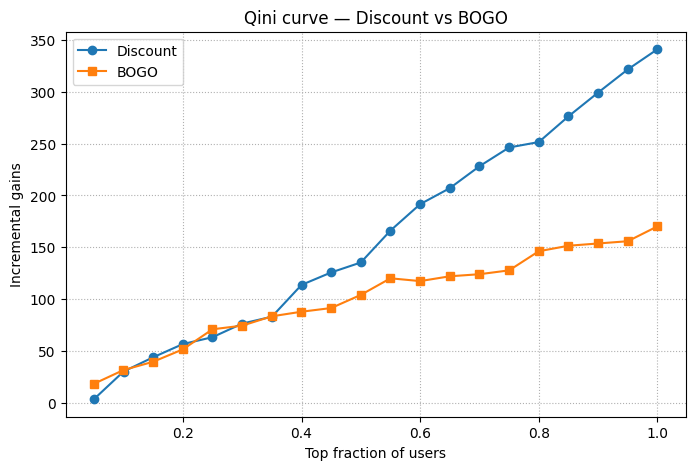

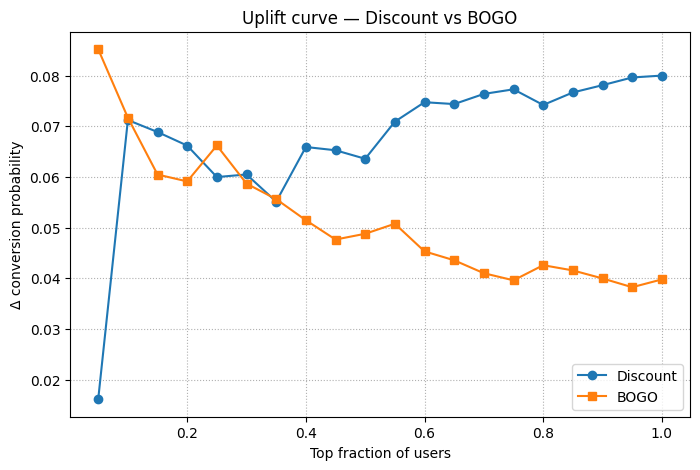

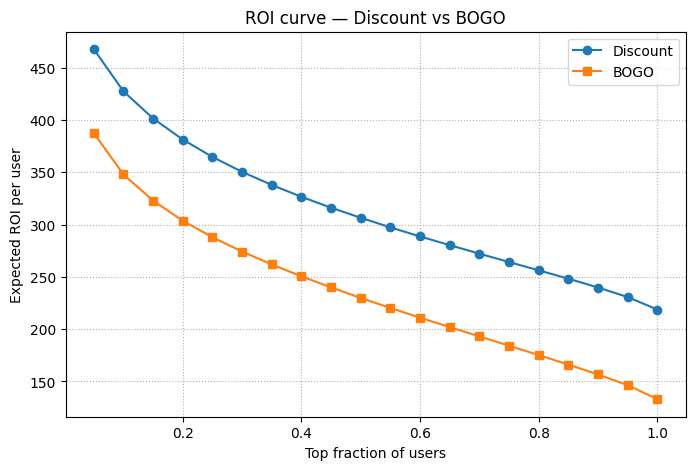

Saved: /kaggle/working//figs/qini_combined.png, /kaggle/working//figs/uplift_curve_combined.png, /kaggle/working//figs/roi_curve_combined.png


In [28]:

res_discount = train_two_model_uplift(df, "Discount")
res_bogo     = train_two_model_uplift(df, "Buy One Get One")

# Create output dir
OUTDIR = globals().get("OUTDIR", "./")
Path(f"{OUTDIR}/figs").mkdir(parents=True, exist_ok=True)

# Convenience: unpack results
rD, rB = res_discount, res_bogo

# --- 1) Qini (both campaigns on one figure) ---
xD_q, yD_q, _ = qini_curve(rD["uplift"], rD["y_test"], rD["t_test"])
xB_q, yB_q, _ = qini_curve(rB["uplift"], rB["y_test"], rB["t_test"])

plt.figure(figsize=(8,5))
plt.plot(xD_q, yD_q, marker="o", label="Discount")
plt.plot(xB_q, yB_q, marker="s", label="BOGO")
plt.xlabel("Top fraction of users")
plt.ylabel("Incremental gains")
plt.title("Qini curve — Discount vs BOGO")
plt.grid(True, linestyle=":")
plt.legend()
plt.savefig(f"{OUTDIR}/figs/qini_combined.png", dpi=160, bbox_inches="tight")
plt.show()

# --- 2) Uplift (both campaigns on one figure) ---
xD_u, yD_u = uplift_curve(rD["uplift"], rD["y_test"], rD["t_test"])
xB_u, yB_u = uplift_curve(rB["uplift"], rB["y_test"], rB["t_test"])

plt.figure(figsize=(8,5))
plt.plot(xD_u, yD_u, marker="o", label="Discount")
plt.plot(xB_u, yB_u, marker="s", label="BOGO")
plt.xlabel("Top fraction of users")
plt.ylabel("Δ conversion probability")
plt.title("Uplift curve — Discount vs BOGO")
plt.grid(True, linestyle=":")
plt.legend()
plt.savefig(f"{OUTDIR}/figs/uplift_curve_combined.png", dpi=160, bbox_inches="tight")
plt.show()

# --- 3) ROI (both campaigns on one figure) ---
xD_r, yD_r = roi_curve(rD["uplift"], MESSAGE_COST, AVG_MARGIN)
xB_r, yB_r = roi_curve(rB["uplift"], MESSAGE_COST, AVG_MARGIN)

plt.figure(figsize=(8,5))
plt.plot(xD_r, yD_r, marker="o", label="Discount")
plt.plot(xB_r, yB_r, marker="s", label="BOGO")
plt.xlabel("Top fraction of users")
plt.ylabel("Expected ROI per user")
plt.title("ROI curve — Discount vs BOGO")
plt.grid(True, linestyle=":")
plt.legend()
plt.savefig(f"{OUTDIR}/figs/roi_curve_combined.png", dpi=160, bbox_inches="tight")
plt.show()

print("Saved:",
      f"{OUTDIR}/figs/qini_combined.png,",
      f"{OUTDIR}/figs/uplift_curve_combined.png,",
      f"{OUTDIR}/figs/roi_curve_combined.png")

In [14]:

def uplift_at_k(uplift, y, t, frac):
    order = np.argsort(-uplift)
    k = max(1, int(len(order)*frac))
    sel = order[:k]
    y_t = y[sel][t[sel]==1]
    y_c = y[sel][t[sel]==0]
    return (y_t.mean() if len(y_t) else 0) - (y_c.mean() if len(y_c) else 0)

import pandas as pd
rows = []
for tag, res in [("discount", res_discount), ("bogo", res_bogo)]:
    for frac in [0.1, 0.2, 0.3]:
        rows.append(dict(offer=tag, k=f"{int(frac*100)}%", uplift_at_k=round(uplift_at_k(res["uplift"], res["y_test"], res["t_test"], frac),6)))
uplift_table = pd.DataFrame(rows)
uplift_table


,offer,k,uplift_at_k
0,discount,10%,0.071216
1,discount,20%,0.066176
2,discount,30%,0.060479
3,bogo,10%,0.071677
4,bogo,20%,0.059111
5,bogo,30%,0.058673


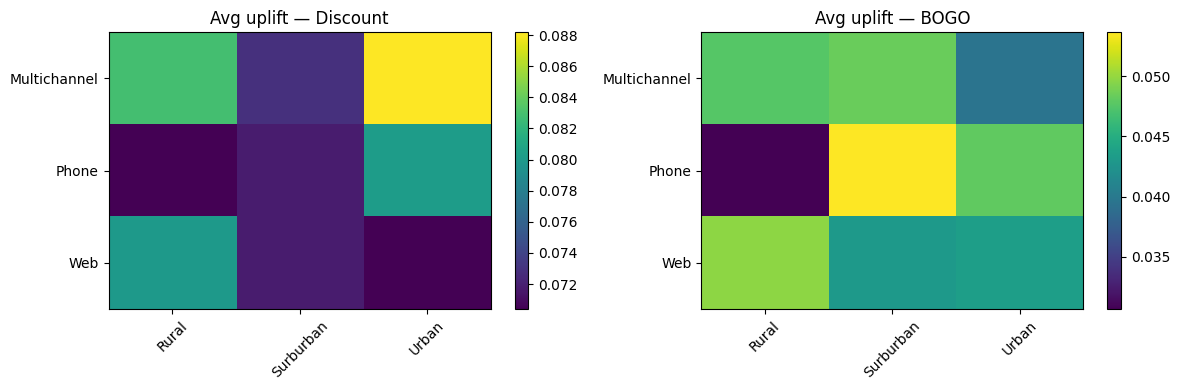

(zip_code         Rural  Surburban     Urban
 channel                                    
 Multichannel  0.082848   0.072889  0.088182
 Phone         0.070413   0.071773  0.080263
 Web           0.079952   0.071777  0.070404,
 zip_code         Rural  Surburban     Urban
 channel                                    
 Multichannel  0.047554   0.048381  0.039559
 Phone         0.030696   0.053624  0.048057
 Web           0.049743   0.042971  0.043522)

In [15]:
# Сегментная "тепловая" карта uplift (channel x zip_code) — оценим средний uplift по тесту
def segment_uplift_table(df_full, res, seg_col1="channel", seg_col2="zip_code"):
    test_idx = res["X_test"].index
    part = df_full.loc[test_idx, [seg_col1, seg_col2]].copy()
    part["uplift"] = res["uplift"]
    return part.pivot_table(index=seg_col1, columns=seg_col2, values="uplift", aggfunc="mean")

seg_discount = segment_uplift_table(df, res_discount)
seg_bogo     = segment_uplift_table(df, res_bogo)

fig, axes = plt.subplots(1,2, figsize=(12,4))
im0 = axes[0].imshow(seg_discount.values, aspect="auto")
axes[0].set_title("Avg uplift — Discount")
axes[0].set_xticks(range(len(seg_discount.columns))); axes[0].set_xticklabels(seg_discount.columns, rotation=45)
axes[0].set_yticks(range(len(seg_discount.index)));  axes[0].set_yticklabels(seg_discount.index)
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(seg_bogo.values, aspect="auto")
axes[1].set_title("Avg uplift — BOGO")
axes[1].set_xticks(range(len(seg_bogo.columns))); axes[1].set_xticklabels(seg_bogo.columns, rotation=45)
axes[1].set_yticks(range(len(seg_bogo.index)));  axes[1].set_yticklabels(seg_bogo.index)
plt.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.savefig(f"{OUTDIR}/figs/segment_uplift_heatmaps.png", dpi=160, bbox_inches="tight")
plt.show()

seg_discount, seg_bogo


In [16]:

def fit_full_and_score(local_df, treat_value):
    subset = local_df[(local_df['offer']==treat_value) | (local_df['offer']=="No Offer")].copy()
    subset['treat'] = (subset['offer']==treat_value).astype(int)

    X = subset[num_cols + cat_cols].copy()
    y = subset['conversion'].astype(int).values
    t = subset['treat'].astype(int).values

    prep = build_preprocess()
    model_t = Pipeline([("prep", prep), ("clf", make_clf())])
    model_c = Pipeline([("prep", prep), ("clf", make_clf())])

    model_t.fit(X[t==1], y[t==1])
    model_c.fit(X[t==0], y[t==0])

    X_all = local_df[num_cols + cat_cols].copy()
    p_t = model_t.predict_proba(X_all)[:,1]
    p_c = model_c.predict_proba(X_all)[:,1]
    return p_t - p_c

uplift_d_full = fit_full_and_score(df, "Discount")
uplift_b_full = fit_full_and_score(df, "Buy One Get One")

scores = pd.DataFrame({
    "uplift_discount": uplift_d_full,
    "uplift_bogo": uplift_b_full,
})

scores["best_offer"] = "No Offer"
scores.loc[scores["uplift_discount"] > 0, "best_offer"] = "Discount"
scores.loc[scores["uplift_bogo"] > scores["uplift_discount"], "best_offer"] = "Buy One Get One"
scores.loc[(scores["uplift_discount"] <= 0) & (scores["uplift_bogo"] <= 0), "best_offer"] = "No Offer"

scores["expected_uplift"] = scores[["uplift_discount","uplift_bogo"]].max(axis=1)
scores["expected_roi_per_user"] = scores["expected_uplift"] * AVG_MARGIN - MESSAGE_COST

scores_path = f"{OUTDIR}/scores.csv"
scores.to_csv(scores_path, index=False)
scores.head()


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,uplift_discount,uplift_bogo,best_offer,expected_uplift,expected_roi_per_user
0,0.042092,0.043167,Buy One Get One,0.043167,124.501846
1,0.051270,-0.037531,Discount,0.051270,148.810814
2,0.050961,0.056931,Buy One Get One,0.056931,165.791507
3,0.054706,0.024265,Discount,0.054706,159.119199
4,0.118567,0.043937,Discount,0.118567,350.699733


In [17]:
# Краткое резюме uplift@K (для отчёта)
def uplift_at_k_summary(res):
    return {
        "u10": round(uplift_at_k(res["uplift"], res["y_test"], res["t_test"], 0.1), 6),
        "u20": round(uplift_at_k(res["uplift"], res["y_test"], res["t_test"], 0.2), 6),
        "u30": round(uplift_at_k(res["uplift"], res["y_test"], res["t_test"], 0.3), 6),
    }

summary = {
    "discount": uplift_at_k_summary(res_discount),
    "bogo": uplift_at_k_summary(res_bogo),
    "message_cost": MESSAGE_COST,
    "avg_margin": AVG_MARGIN,
    "scores_csv": scores_path,
    "figs": [
        f"{OUTDIR}/figs/qini_discount.png",
        f"{OUTDIR}/figs/qini_bogo.png",
        f"{OUTDIR}/figs/uplift_curve_discount.png",
        f"{OUTDIR}/figs/uplift_curve_bogo.png",
        f"{OUTDIR}/figs/roi_curve_discount.png",
        f"{OUTDIR}/figs/roi_curve_bogo.png",
        f"{OUTDIR}/figs/segment_uplift_heatmaps.png",
    ],
}
import json, pprint
print(json.dumps(summary, ensure_ascii=False, indent=2))


{
  "discount": {
    "u10": 0.071216,
    "u20": 0.066176,
    "u30": 0.060479
  },
  "bogo": {
    "u10": 0.071677,
    "u20": 0.059111,
    "u30": 0.058673
  },
  "message_cost": 5.0,
  "avg_margin": 3000.0,
  "scores_csv": "/kaggle/working//scores.csv",
  "figs": [
    "/kaggle/working//figs/qini_discount.png",
    "/kaggle/working//figs/qini_bogo.png",
    "/kaggle/working//figs/uplift_curve_discount.png",
    "/kaggle/working//figs/uplift_curve_bogo.png",
    "/kaggle/working//figs/roi_curve_discount.png",
    "/kaggle/working//figs/roi_curve_bogo.png",
    "/kaggle/working//figs/segment_uplift_heatmaps.png"
  ]
}


Обучим s-learner. Добавим в качестве признака в данные переменную, показывающую, был ли в контрльной группе человек, или нет.

In [18]:
def s_learner_uplift(local_df, treat_value, random_state=RANDOM_STATE):
    """Обучает S-Learner для одного типа предложения против контроля."""
    subset = local_df[(local_df['offer']==treat_value) | (local_df['offer']=="No Offer")].copy()
    subset['treat'] = (subset['offer']==treat_value).astype(int)
    y = subset['conversion'].astype(int).values
    t = subset['treat'].astype(int).values
    X = subset[num_cols + cat_cols].copy()
    
    # Добавляем признак лечения к фичам
    X_sl = X.copy()
    X_sl['treat'] = t

    # Делим данные
    X_tr, X_te, y_tr, y_te, t_tr, t_te = train_test_split(
        X_sl, y, t, test_size=0.2, stratify=t, random_state=random_state
    )

    # Создаем препроцессор для S-Learner (учитываем новый признак 'treat')
    def build_preprocess_sl():
        return ColumnTransformer([
            ("num", "passthrough", num_cols + ['treat']),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
        ])

    # Обучаем одну модель на ВСЕХ обучающих данных
    model_sl = Pipeline([
        ("prep", build_preprocess_sl()), 
        ("clf", make_clf(random_state))
    ])
    model_sl.fit(X_tr, y_tr)

    # Для предсказания: создаем две копии тестовых данных
    X_te_t1 = X_te.copy()
    X_te_t1['treat'] = 1
    X_te_t0 = X_te.copy()
    X_te_t0['treat'] = 0

    # Предсказываем вероятности
    p_t = model_sl.predict_proba(X_te_t1)[:, 1]
    p_c = model_sl.predict_proba(X_te_t0)[:, 1]
    uplift_sl = p_t - p_c

    return {
        'X_test': X_te, 
        'y_test': y_te, 
        't_test': t_te, 
        'uplift': uplift_sl,
        'model': model_sl,
        'test_index': X_te.index
    }

# Обучаем S-Learner для обоих типов предложений
res_discount_sl = s_learner_uplift(df, "Discount")
res_bogo_sl = s_learner_uplift(df, "Buy One Get One")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Строим графики сравнения s-learner и t-learner.

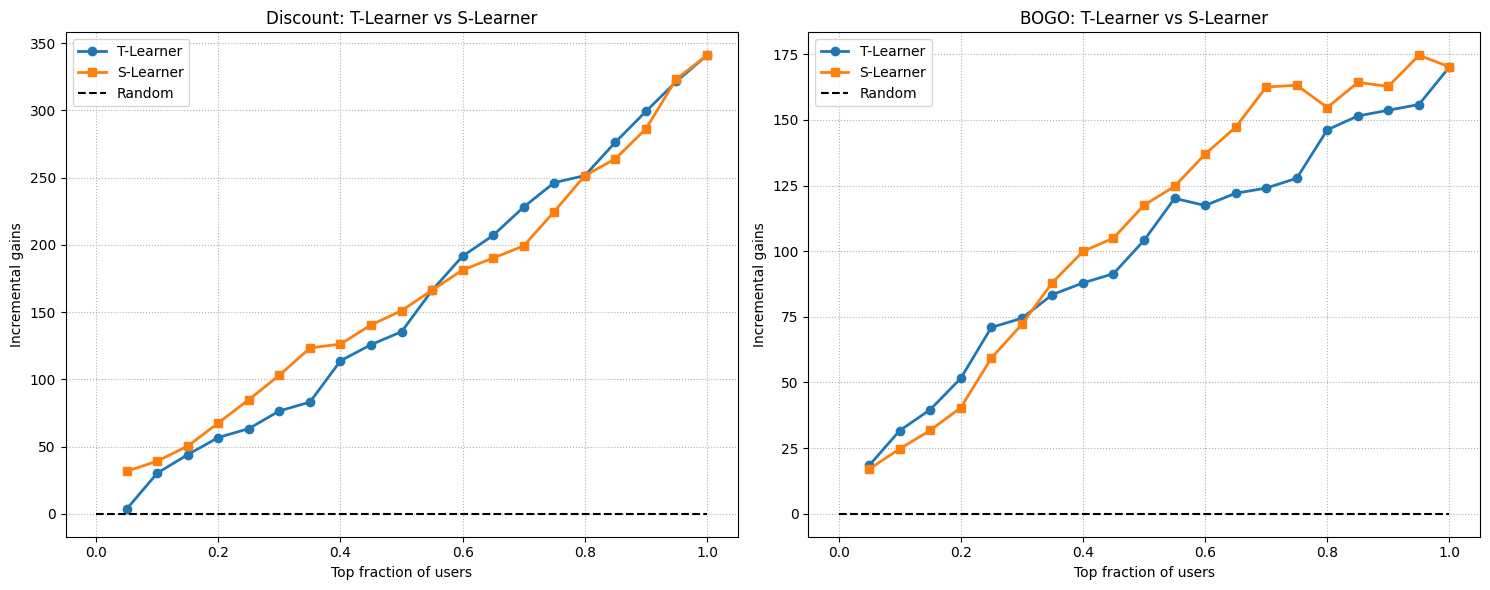


=== Discount Uplift Comparison ===
Top 10%: T-Learner=0.0712, S-Learner=0.0913, Diff=-0.0201
Top 20%: T-Learner=0.0662, S-Learner=0.0780, Diff=-0.0118
Top 30%: T-Learner=0.0605, S-Learner=0.0806, Diff=-0.0201

=== BOGO Uplift Comparison ===
Top 10%: T-Learner=0.0717, S-Learner=0.0571, Diff=0.0146
Top 20%: T-Learner=0.0591, S-Learner=0.0475, Diff=0.0116
Top 30%: T-Learner=0.0587, S-Learner=0.0562, Diff=0.0025


In [19]:
# Создаем сравнительные графики для обоих типов предложений
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Discount сравнение
xD_t, yD_t, _ = qini_curve(res_discount["uplift"], res_discount["y_test"], res_discount["t_test"])
xD_s, yD_s, _ = qini_curve(res_discount_sl["uplift"], res_discount_sl["y_test"], res_discount_sl["t_test"])

axes[0].plot(xD_t, yD_t, marker="o", label="T-Learner", linewidth=2)
axes[0].plot(xD_s, yD_s, marker="s", label="S-Learner", linewidth=2)
axes[0].plot([0, 1], [0, 0], 'k--', label='Random')
axes[0].set_xlabel("Top fraction of users")
axes[0].set_ylabel("Incremental gains")
axes[0].set_title("Discount: T-Learner vs S-Learner")
axes[0].grid(True, linestyle=":")
axes[0].legend()

# BOGO сравнение
xB_t, yB_t, _ = qini_curve(res_bogo["uplift"], res_bogo["y_test"], res_bogo["t_test"])
xB_s, yB_s, _ = qini_curve(res_bogo_sl["uplift"], res_bogo_sl["y_test"], res_bogo_sl["t_test"])

axes[1].plot(xB_t, yB_t, marker="o", label="T-Learner", linewidth=2)
axes[1].plot(xB_s, yB_s, marker="s", label="S-Learner", linewidth=2)
axes[1].plot([0, 1], [0, 0], 'k--', label='Random')
axes[1].set_xlabel("Top fraction of users")
axes[1].set_ylabel("Incremental gains")
axes[1].set_title("BOGO: T-Learner vs S-Learner")
axes[1].grid(True, linestyle=":")
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{OUTDIR}/figs/tlearner_vs_slearner_comparison.png", dpi=160, bbox_inches="tight")
plt.show()

# Сравним метрики uplift@k
def print_uplift_comparison(res_t, res_s, treatment_name):
    print(f"\n=== {treatment_name} Uplift Comparison ===")
    for frac in [0.1, 0.2, 0.3]:
        uplift_t = uplift_at_k(res_t["uplift"], res_t["y_test"], res_t["t_test"], frac)
        uplift_s = uplift_at_k(res_s["uplift"], res_s["y_test"], res_s["t_test"], frac)
        print(f"Top {int(frac*100)}%: T-Learner={uplift_t:.4f}, S-Learner={uplift_s:.4f}, Diff={uplift_t-uplift_s:.4f}")

print_uplift_comparison(res_discount, res_discount_sl, "Discount")
print_uplift_comparison(res_bogo, res_bogo_sl, "BOGO")

Теперь 

In [37]:
from sklearn.isotonic import IsotonicRegression

def calibrate_uplift_scores(uplift_scores, y_true, t_true, n_bins=10):
    """Калибрует uplift scores на основе реальных данных"""
    # Бинаризуем данные по децилям uplift
    bins = np.percentile(uplift_scores, np.linspace(0, 100, n_bins + 1))
    bin_indices = np.digitize(uplift_scores, bins) - 1
    
    # Вычисляем реальный uplift для каждого бина
    real_uplifts = []
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            treatment_mask = mask & (t_true == 1)
            control_mask = mask & (t_true == 0)
            if treatment_mask.sum() > 10 and control_mask.sum() > 10:  # Минимальный размер группы
                real_uplift = y_true[treatment_mask].mean() - y_true[control_mask].mean()
                real_uplifts.append(real_uplift)
            else:
                real_uplifts.append(0)
        else:
            real_uplifts.append(0)
    
    # Обучаем калибровочную модель
    calibrated_model = IsotonicRegression(out_of_bounds='clip')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    calibrated_model.fit(bin_centers[:len(real_uplifts)], real_uplifts)
    
    # Калибруем scores
    calibrated_scores = calibrated_model.transform(uplift_scores)
    return calibrated_scores


In [45]:
def apply_combined_strategy(df, discount_model, bogo_model, model_type="S-Learner", calibrate_scores=True):
    """
    Применяет комбинированную стратегию с опциональной калибровкой uplift scores
    """
    # Получаем фичи для всех клиентов
    X_all = df[num_cols + cat_cols].copy()
    
    if model_type == "S-Learner":
        # Для S-Learner: создаем два варианта данных (с treatment=1 и treatment=0)
        X_t1 = X_all.copy()
        X_t1['treat'] = 1
        X_t0 = X_all.copy()
        X_t0['treat'] = 0
        
        # Предсказания для Discount - используем модель из словаря
        p_discount_t1 = discount_model['model'].predict_proba(X_t1)[:, 1]  # Исправлено
        p_discount_t0 = discount_model['model'].predict_proba(X_t0)[:, 1]  # Исправлено
        uplift_discount = p_discount_t1 - p_discount_t0
        
        # Предсказания для BOGO - используем модель из словаря
        p_bogo_t1 = bogo_model['model'].predict_proba(X_t1)[:, 1]  # Исправлено
        p_bogo_t0 = bogo_model['model'].predict_proba(X_t0)[:, 1]  # Исправлено
        uplift_bogo = p_bogo_t1 - p_bogo_t0
        
    else:  # T-Learner
        # Для T-Learner: используем отдельные модели для treatment и control
        # Discount модель
        p_discount_t = discount_model['model_t'].predict_proba(X_all)[:, 1]
        p_discount_c = discount_model['model_c'].predict_proba(X_all)[:, 1]
        uplift_discount = p_discount_t - p_discount_c
        
        # BOGO модель
        p_bogo_t = bogo_model['model_t'].predict_proba(X_all)[:, 1]
        p_bogo_c = bogo_model['model_c'].predict_proba(X_all)[:, 1]
        uplift_bogo = p_bogo_t - p_bogo_c
    
    # ⭐⭐⭐ ВСТАВЛЯЕМ КАЛИБРОВКУ ЗДЕСЬ ⭐⭐⭐
    if calibrate_scores:
        print("Применяем калибровку uplift scores...")
        
        # Для калибровки нужны настоящие данные о конверсии и лечении
        # Используем тестовые данные из одной из моделей для калибровки
        try:
            # Берем тестовые данные (например, из discount модели)
            if 'X_test' in discount_model and 'y_test' in discount_model and 't_test' in discount_model:
                X_test = discount_model['X_test']
                y_test = discount_model['y_test']
                t_test = discount_model['t_test']
                
                # Предсказываем uplift на тестовых данных для калибровки
                if model_type == "S-Learner":
                    X_test_t1 = X_test.copy()
                    X_test_t1['treat'] = 1
                    X_test_t0 = X_test.copy()
                    X_test_t0['treat'] = 0
                    
                    # Исправлено: используем модель из словаря
                    test_p_discount_t1 = discount_model['model'].predict_proba(X_test_t1)[:, 1]
                    test_p_discount_t0 = discount_model['model'].predict_proba(X_test_t0)[:, 1]
                    test_uplift_discount = test_p_discount_t1 - test_p_discount_t0
                    
                    test_p_bogo_t1 = bogo_model['model'].predict_proba(X_test_t1)[:, 1]
                    test_p_bogo_t0 = bogo_model['model'].predict_proba(X_test_t0)[:, 1]
                    test_uplift_bogo = test_p_bogo_t1 - test_p_bogo_t0
                    
                else:  # T-Learner
                    test_p_discount_t = discount_model['model_t'].predict_proba(X_test)[:, 1]
                    test_p_discount_c = discount_model['model_c'].predict_proba(X_test)[:, 1]
                    test_uplift_discount = test_p_discount_t - test_p_discount_c
                    
                    test_p_bogo_t = bogo_model['model_t'].predict_proba(X_test)[:, 1]
                    test_p_bogo_c = bogo_model['model_c'].predict_proba(X_test)[:, 1]
                    test_uplift_bogo = test_p_bogo_t - test_p_bogo_c
                
                # Калибруем scores
                uplift_discount = calibrate_uplift_scores(
                    uplift_discount, test_uplift_discount, y_test, t_test
                )
                uplift_bogo = calibrate_uplift_scores(
                    uplift_bogo, test_uplift_bogo, y_test, t_test
                )
                print("Калибровка завершена!")
            else:
                print("Тестовые данные не найдены, пропускаем калибровку")
        except Exception as e:
            print(f"Ошибка при калибровке: {e}, используем неколиброванные scores")
    
    # Выбираем лучший оффер для каждого клиента с порогом значимости
    max_uplift = np.maximum(uplift_discount, uplift_bogo)
    
    # Используем консервативный порог (топ 30% или uplift > 0.01)
    conservative_threshold = max(np.percentile(max_uplift, 70), 0.01)
    
    best_offer = np.where(
        max_uplift > conservative_threshold,
        np.where(uplift_discount > uplift_bogo, 'Discount', 'BOGO'),
        'No Offer'
    )
    
    best_uplift = np.where(
        best_offer != 'No Offer', 
        np.where(best_offer == 'Discount', uplift_discount, uplift_bogo),
        0
    )
    
    return {
        'best_offer': best_offer,
        'best_uplift': best_uplift,
        'uplift_discount': uplift_discount,
        'uplift_bogo': uplift_bogo,
        'model_type': model_type,
        'calibrated': calibrate_scores
    }

# Добавляем функцию калибровки ПЕРЕД основной функцией
def calibrate_uplift_scores(uplift_scores, test_uplift_scores, y_test, t_test, n_bins=10):
    """Калибрует uplift scores на основе реальных данных"""
    # Используем тестовые данные для калибровки
    calibrated_scores = uplift_scores.copy()
    
    # Бинаризуем тестовые данные по децилям predicted uplift
    bins = np.percentile(test_uplift_scores, np.linspace(0, 100, n_bins + 1))
    bin_indices = np.digitize(test_uplift_scores, bins) - 1
    
    # Вычисляем реальный uplift для каждого бина на тестовых данных
    bin_real_uplifts = []
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 20:  # Минимальный размер группы
            treatment_conv = y_test[mask & (t_test == 1)].mean()
            control_conv = y_test[mask & (t_test == 0)].mean()
            real_uplift = treatment_conv - control_conv
            bin_real_uplifts.append(real_uplift)
        else:
            bin_real_uplifts.append(0)
    
    # Применяем калибровку ко всем данным
    for i in range(n_bins):
        if i < len(bin_real_uplifts) and bin_real_uplifts[i] != 0:
            lower, upper = bins[i], bins[i+1]
            mask = (uplift_scores >= lower) & (uplift_scores < upper)
            # Заменяем predicted uplift на реальный из соответствующего бина
            calibrated_scores[mask] = bin_real_uplifts[i]
    
    return calibrated_scores

def evaluate_combined_strategy_real_performance(df, strategy_results, test_mask=None):
    """
    Оценивает реальную производительность комбинированной стратегии
    """
    if test_mask is None:
        # Используем все данные для оценки
        test_mask = np.ones(len(df), dtype=bool)
    
    df_test = df[test_mask].copy()
    best_offer = strategy_results['best_offer'][test_mask]
    best_uplift = strategy_results['best_uplift'][test_mask]
    
    # Целевая группа: клиенты, которым предлагается оффер
    target_mask = best_offer != 'No Offer'
    
    if target_mask.sum() == 0:
        # Если никто не получил оффер
        return {
            'target_conversion': 0,
            'control_conversion': df_test['conversion'].mean(),
            'real_uplift': -df_test['conversion'].mean(),
            'p_value': 1.0,
            'target_count': 0,
            'control_count': len(df_test),
            'offer_distribution': {'No Offer': len(df_test)}
        }
    
    # Реальная конверсия в целевой группе
    target_conversion = df_test.loc[target_mask, 'conversion'].mean()
    
    # Контрольная группа: клиенты без оффера
    control_conversion = df_test.loc[~target_mask, 'conversion'].mean()
    
    # Реальный uplift
    real_uplift = target_conversion - control_conversion
    
    # Статистическая значимость
    successes = np.array([
        df_test.loc[target_mask, 'conversion'].sum(),
        df_test.loc[~target_mask, 'conversion'].sum()
    ])
    trials = np.array([target_mask.sum(), (~target_mask).sum()])
    
    z_stat, p_value = proportions_ztest(successes, trials, alternative='larger')
    
    # Распределение офферов
    offer_distribution = {
        'Discount': (best_offer == 'Discount').sum(),
        'BOGO': (best_offer == 'BOGO').sum(),
        'No Offer': (best_offer == 'No Offer').sum()
    }
    
    return {
        'target_conversion': target_conversion,
        'control_conversion': control_conversion,
        'real_uplift': real_uplift,
        'p_value': p_value,
        'target_count': target_mask.sum(),
        'control_count': (~target_mask).sum(),
        'offer_distribution': offer_distribution,
        'model_type': strategy_results['model_type']
    }

print("СРАВНЕНИЕ КОМБИНИРОВАННЫХ СТРАТЕГИЙ: S-LEARNER VS T-LEARNER")
print("=" * 80)

# Применяем S-Learner стратегию С калибровкой
print("Применяем S-Learner стратегию с калибровкой...")
slearner_strategy = apply_combined_strategy(
    df, 
    res_discount_sl,  # Словарь с моделью в ключе 'model'
    res_bogo_sl,      # Словарь с моделью в ключе 'model'  
    model_type="S-Learner",
    calibrate_scores=True
)

# Применяем T-Learner стратегию С калибровкой
print("Применяем T-Learner стратегию с калибровкой...")
tlearner_strategy = apply_combined_strategy(
    df, 
    res_discount,  # T-Learner словарь с 'model_t' и 'model_c'
    res_bogo,      # T-Learner словарь с 'model_t' и 'model_c'
    model_type="T-Learner",
    calibrate_scores=True
)

# Оцениваем на тестовых данных
test_indices = res_discount_sl['test_index']
test_mask = df.index.isin(test_indices)

print("Оцениваем реальную производительность...")
slearner_performance = evaluate_combined_strategy_real_performance(
    df, slearner_strategy, test_mask
)

tlearner_performance = evaluate_combined_strategy_real_performance(
    df, tlearner_strategy, test_mask
)

# Результаты
results = [slearner_performance, tlearner_performance]

# Выводим результаты
print("\nРЕЗУЛЬТАТЫ КОМБИНИРОВАННЫХ СТРАТЕГИЙ:")
print("=" * 80)
print(f"{'Стратегия':<15} {'Target CR':<10} {'Control CR':<10} {'Real Uplift':<12} {'p-value':<10} {'Значимо':<10} {'Target Size':<12}")
print("-" * 80)

for result in results:
    significance = "ДА" if result['p_value'] < 0.05 else "НЕТ"
    print(f"{result['model_type']:<15} {result['target_conversion']:.4f}    {result['control_conversion']:.4f}    "
          f"{result['real_uplift']:.4f}      {result['p_value']:.4f}    {significance:<10} {result['target_count']:<12}")
# Распределение офферов
print("\nРАСПРЕДЕЛЕНИЕ ОФФЕРОВ:")
print("=" * 50)
for result in results:
    print(f"\n{result['model_type']}:")
    for offer, count in result['offer_distribution'].items():
        percentage = count / (result['target_count'] + result['control_count']) * 100
        print(f"  {offer}: {count} ({percentage:.1f}%)")

СРАВНЕНИЕ КОМБИНИРОВАННЫХ СТРАТЕГИЙ: S-LEARNER VS T-LEARNER
Применяем S-Learner стратегию с калибровкой...
Применяем калибровку uplift scores...
Калибровка завершена!
Применяем T-Learner стратегию с калибровкой...
Применяем калибровку uplift scores...
Калибровка завершена!
Оцениваем реальную производительность...

РЕЗУЛЬТАТЫ КОМБИНИРОВАННЫХ СТРАТЕГИЙ:
Стратегия       Target CR  Control CR Real Uplift  p-value    Значимо    Target Size 
--------------------------------------------------------------------------------
S-Learner       0.1685    0.1396    0.0289      0.0004    ДА         2327        
T-Learner       0.1603    0.1425    0.0178      0.0191    ДА         2377        

РАСПРЕДЕЛЕНИЕ ОФФЕРОВ:

S-Learner:
  Discount: 1706 (20.0%)
  BOGO: 621 (7.3%)
  No Offer: 6196 (72.7%)

T-Learner:
  Discount: 853 (10.0%)
  BOGO: 1524 (17.9%)
  No Offer: 6146 (72.1%)


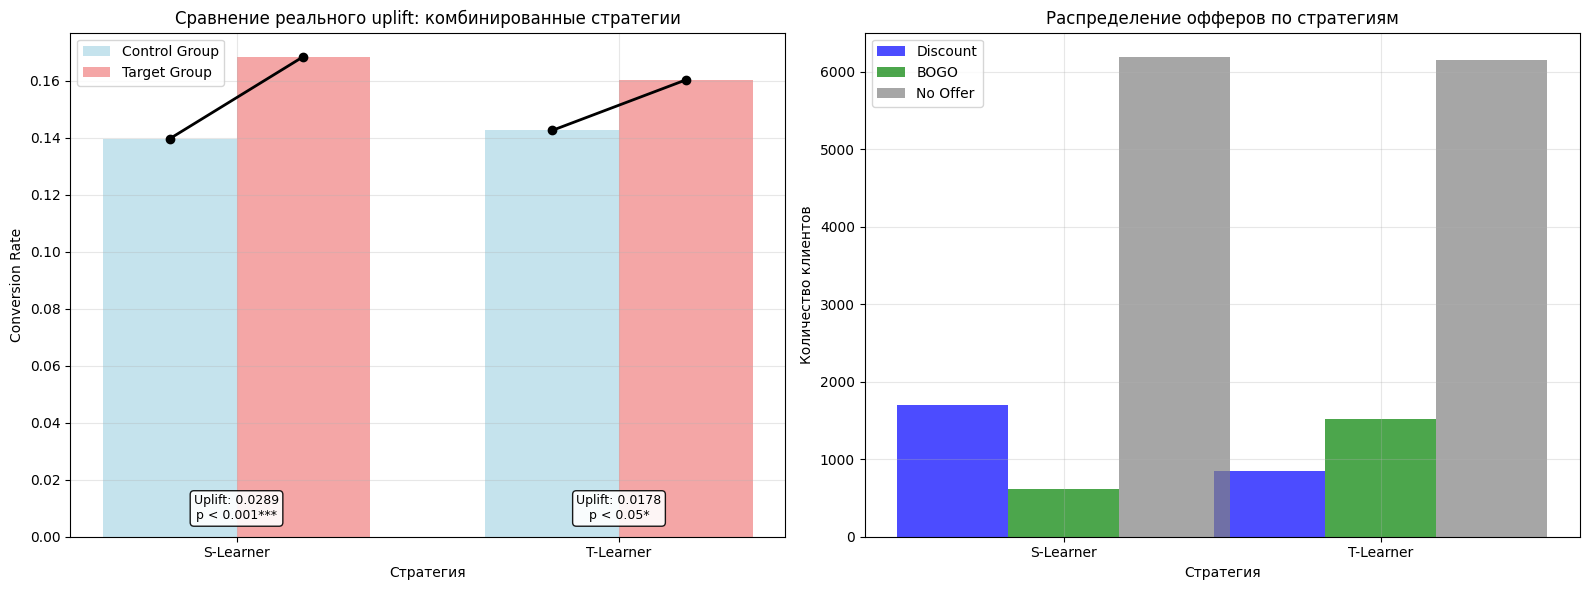


СТАТИСТИЧЕСКОЕ СРАВНЕНИЕ СТРАТЕГИЙ:
Разница в uplift (S-Learner - T-Learner): 0.0110
95% доверительный интервал: [-0.0077, 0.0305]
p-value: 0.2680
Статистически значимое различие: НЕТ
➖ Нет значимого различия между стратегиями


In [48]:
# Визуализация
def plot_combined_strategies_comparison(results):
    """
    Визуализирует сравнение комбинированных стратегий
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # График 1: Сравнение конверсий
    model_types = [r['model_type'] for r in results]
    control_rates = [r['control_conversion'] for r in results]
    target_rates = [r['target_conversion'] for r in results]
    uplifts = [r['real_uplift'] for r in results]
    p_values = [r['p_value'] for r in results]
    
    x_pos = np.arange(len(model_types))
    bar_width = 0.35
    
    bars1 = ax1.bar(x_pos - bar_width/2, control_rates, bar_width, 
                   label='Control Group', color='lightblue', alpha=0.7)
    bars2 = ax1.bar(x_pos + bar_width/2, target_rates, bar_width, 
                   label='Target Group', color='lightcoral', alpha=0.7)
    
    # Добавляем uplift и значимость
    for i, (control, target, uplift, p_val) in enumerate(zip(control_rates, target_rates, uplifts, p_values)):
        ax1.plot([i - bar_width/2, i + bar_width/2], [control, target], 
                color='black', linewidth=2, marker='o')
        
        uplift_text = f"Uplift: {uplift:.4f}\n"
        if p_val < 0.001:
            uplift_text += "p < 0.001***"
        elif p_val < 0.01:
            uplift_text += "p < 0.01**"
        elif p_val < 0.05:
            uplift_text += "p < 0.05*"
        else:
            uplift_text += f"p = {p_val:.3f}"
        
        ax1.text(i, 0.005, uplift_text, 
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    ax1.set_xlabel('Стратегия')
    ax1.set_ylabel('Conversion Rate')
    ax1.set_title('Сравнение реального uplift: комбинированные стратегии')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_types)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Распределение офферов
    offer_data = {}
    for result in results:
        model_type = result['model_type']
        offer_data[model_type] = result['offer_distribution']
    
    discount_counts = [offer_data[model]['Discount'] for model in model_types]
    bogo_counts = [offer_data[model]['BOGO'] for model in model_types]
    no_offer_counts = [offer_data[model]['No Offer'] for model in model_types]
    
    ax2.bar(x_pos - bar_width, discount_counts, bar_width, label='Discount', color='blue', alpha=0.7)
    ax2.bar(x_pos, bogo_counts, bar_width, label='BOGO', color='green', alpha=0.7)
    ax2.bar(x_pos + bar_width, no_offer_counts, bar_width, label='No Offer', color='gray', alpha=0.7)
    
    ax2.set_xlabel('Стратегия')
    ax2.set_ylabel('Количество клиентов')
    ax2.set_title('Распределение офферов по стратегиям')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_types)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Строим графики
fig = plot_combined_strategies_comparison(results)
plt.savefig(f"{OUTDIR}/figs/combined_strategies_comparison.png", dpi=160, bbox_inches="tight")
plt.show()

# Статистическое сравнение стратегий
print("\nСТАТИСТИЧЕСКОЕ СРАВНЕНИЕ СТРАТЕГИЙ:")
print("=" * 60)

# Бутстреп для сравнения uplift
n_bootstrap = 1000
uplift_diffs = []

for _ in range(n_bootstrap):
    # Ресэмплинг тестовых индексов
    boot_indices = np.random.choice(test_indices, size=len(test_indices), replace=True)
    boot_mask = df.index.isin(boot_indices)
    
    # Оценка производительности на бутстреп выборке
    slearner_boot = evaluate_combined_strategy_real_performance(df, slearner_strategy, boot_mask)
    tlearner_boot = evaluate_combined_strategy_real_performance(df, tlearner_strategy, boot_mask)
    
    uplift_diffs.append(slearner_boot['real_uplift'] - tlearner_boot['real_uplift'])

uplift_diffs = np.array(uplift_diffs)
p_value = 2 * min((uplift_diffs < 0).mean(), (uplift_diffs > 0).mean())
ci_lower, ci_upper = np.percentile(uplift_diffs, [2.5, 97.5])

print(f"Разница в uplift (S-Learner - T-Learner): {np.mean(uplift_diffs):.4f}")
print(f"95% доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"p-value: {p_value:.4f}")
print(f"Статистически значимое различие: {'ДА' if p_value < 0.05 else 'НЕТ'}")

if np.mean(uplift_diffs) > 0 and p_value < 0.05:
    print("✅ S-Learner стратегия значимо лучше")
elif np.mean(uplift_diffs) < 0 and p_value < 0.05:
    print("✅ T-Learner стратегия значимо лучше")
else:
    print("➖ Нет значимого различия между стратегиями")